In [8]:
# imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [9]:
# loding data into pandas df
review = pd.read_json('./preprocessed2Train.json', lines=True)
review

,overall,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image,clean_lemmatized
0,4,"08 24, 2010",u04428712,"So is Katy Perry's new album ""Teenage Dream"" c...",Amazing that I Actually Bought This...More Ama...,1282608000,Pop,$35.93,p70761125,85559980,None,katy perry new album teenage dream contrived d...
1,5,"10 31, 2009",u06946603,"I got this CD almost 10 years ago, and given t...",Excellent album,1256947200,Alternative Rock,$11.28,p85427891,41699565,None,got cd almost 10 year ago given passage time s...
2,4,"10 13, 2015",u92735614,I REALLY enjoy this pairing of Anderson and Po...,"Love the Music, Hate the Light Show",1444694400,Pop,$89.86,p82172532,24751194,None,really enjoy pairing anderson ponty music much...
3,5,"06 28, 2017",u35112935,Finally got it . It was everything thought it ...,Great,1498608000,Pop,$11.89,p15255251,22820631,None,finally got wa everything thought would great ...
4,4,"10 12, 2015",u07141505,"Look at all star cast. Outstanding record, pl...",Love these guys.,1444608000,Jazz,$15.24,p82618188,53377470,None,look star cast outstanding record play impress...
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,4,"05 1, 2004",u68902609,"With this, Mariah's third album, Mariah proved...",Well Done Mariah! You Show 'Em!,1083369600,Pop,$7.98,p84118731,35077372,None,mariahs third album mariah proved wa dynamic l...
199996,5,"02 27, 2017",u15269603,Fantastic CD. All the hits are here and even ...,"Great collection, excellent sound!",1488153600,Pop,$11.49,p08613950,9788722,None,fantastic cd hit even better several debut ori...
199997,3,"03 1, 2011",u25124021,"This recording is rather disappointing, to a c...",Odd Couplings,1298937600,Classical,$13.57,p25341819,71627957,None,recording rather disappointing certain degree ...
199998,5,"03 20, 2016",u04485604,Get it now ! Right now ! I am partial. I am a ...,Our Poet,1458432000,Alternative Rock,$11.07,p19134748,27463540,None,get right partial new yorker get get right par...


In [10]:
# split star rating into individual categories
review = pd.get_dummies(review, columns = ['overall'])

In [11]:
# split train and test data
train, test = train_test_split(review, test_size = 0.3, random_state = 42)

In [12]:
class_names = ['overall_1', 'overall_2', 'overall_3', 'overall_4', 'overall_5']

y_train = train[class_names].values
y_test = test[class_names].values

In [13]:
# using GLoVe word vectors from Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation.
embed_size = 200 
# max number of unique words 
max_features = 20000
# max number of words from review to use
maxlen = 200

# File path for GLoVe
embedding_file = './glove.twitter.27B/glove.twitter.27B.200d.txt'

# read in embeddings
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file))

In [14]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train['clean_lemmatized'].values))
X_train = tokenizer.texts_to_sequences(train['clean_lemmatized'].values)
X_test = tokenizer.texts_to_sequences(test['clean_lemmatized'].values)
x_train = pad_sequences(X_train, maxlen = maxlen)
x_test = pad_sequences(X_test, maxlen = maxlen)

In [15]:
word_index = tokenizer.word_index
includedWord = []

nb_words = min(max_features, len(word_index))
# create a zeros matrix of the correct dimensions 
embedding_matrix = np.zeros((nb_words, embed_size))
missed = []
for word, i in word_index.items():
    if i >= max_features: break
    embedding_vector = embeddings_index.get(word)
    includedWord.append(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        missed.append(word)

In [16]:
embedding_matrix.shape

(20000, 200)

In [17]:
# Using model described in https://www.kaggle.com/athoul01/predicting-yelp-ratings-from-review-text
# Original credit given to https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/52644
inp = Input(shape = (maxlen,))
x = Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = True)(inp)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(40, return_sequences=True))(x)
x = Bidirectional(GRU(40, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(5, activation = 'softmax')(conc)

model = Model(inputs = inp, outputs = outp)
# patience is how many epochs to wait to see if val_loss will improve again.
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)
checkpoint = ModelCheckpoint(monitor = 'val_loss', save_best_only = True, filepath = 'amazon_lstm_gru_weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [18]:
history_glove = model.fit(x_train, y_train, batch_size = 2048, epochs = 20, validation_split = .1,
          callbacks=[earlystop, checkpoint])

Epoch 1/20
62/62 [==============================] - 16s 262ms/step - loss: 0.3561 - accuracy: 0.6266 - val_loss: 0.3171 - val_accuracy: 0.6555
Epoch 2/20
62/62 [==============================] - 16s 250ms/step - loss: 0.3027 - accuracy: 0.6634 - val_loss: 0.2871 - val_accuracy: 0.6729
Epoch 3/20
62/62 [==============================] - 15s 248ms/step - loss: 0.2843 - accuracy: 0.6756 - val_loss: 0.2737 - val_accuracy: 0.6844
Epoch 4/20
62/62 [==============================] - 15s 247ms/step - loss: 0.2729 - accuracy: 0.6886 - val_loss: 0.2661 - val_accuracy: 0.6975
Epoch 5/20
62/62 [==============================] - 15s 248ms/step - loss: 0.2642 - accuracy: 0.6994 - val_loss: 0.2612 - val_accuracy: 0.7016
Epoch 6/20
62/62 [==============================] - 15s 248ms/step - loss: 0.2585 - accuracy: 0.7050 - val_loss: 0.2596 - val_accuracy: 0.7039
Epoch 7/20
62/62 [==============================] - 15s 247ms/step - loss: 0.2539 - accuracy: 0.7107 - val_loss: 0.2578 - val_accuracy: 0.7069

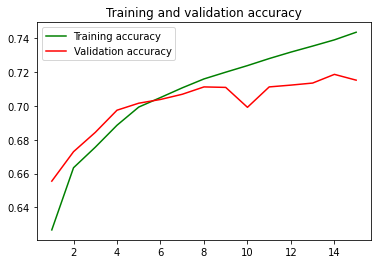

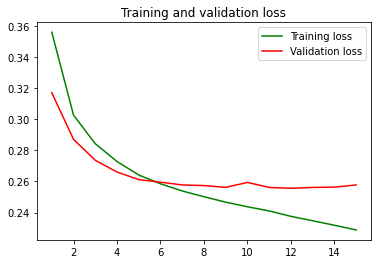

In [19]:
import matplotlib.pyplot as plt

acc = history_glove.history['accuracy']
val_acc = history_glove.history['val_accuracy']
loss = history_glove.history['loss']
val_loss = history_glove.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
y_pred = model.predict([x_test], batch_size=1024, verbose = 1)

59/59 [==============================] - 3s 46ms/step


In [21]:
y_conted = []
for row in y_pred:
    value = row[0] + 2* row[1] + 3*row[2] + 4*row[3] + 5*row[4]
    y_conted.append(value)
pred = pd.DataFrame(data = y_conted)

In [22]:
# pred = pd.DataFrame(data = y_pred, columns =['1', '2', '3', '4', '5'])
# pred = pred.idxmax(axis=1)

label = pd.DataFrame(data = y_test, columns =['1', '2', '3', '4', '5'])
label = label.idxmax(axis=1)

mean_squared_error(label, pred)

0.48959599562835604

# Predict for short users in matrix factorization

In [17]:
test_short = pd.read_json('./p2TestingShortv2.json', lines=True)
test_short

,overall,reviewTime,reviewerID,reviewerID_int,reviewText,summary,unixReviewTime,category,price,itemID,itemID_int,reviewHash,reviewerID_int_count,itemID_int_count
0,4,"01 26, 2005",u23440094,17017,I doubted long between giving this the perfect...,Kid A meets Ok Computer...though not as perfec...,1106697600,Alternative Rock,$7.98,p24253921,6131,18153613,6,136
1,5,"03 9, 2015",u17905699,12975,perfect,Five Stars,1425859200,Alternative Rock,$8.42,p40118584,10128,47177023,2,46
2,5,"07 13, 2015",u49280345,35793,very good,Five Stars,1436745600,Pop,$8.47,p80917931,20701,73695126,1,134
3,5,"07 13, 2014",u19712170,14280,OK well let me start off the shipping was very...,The Legend great cd,1405209600,Jazz,$19.99,p42347694,10690,64861768,1,5
4,5,"12 14, 2014",u05972617,4357,Love Bastille,Love!,1418515200,Alternative Rock,$22.10,p20950427,5321,4481587,4,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25645,5,"07 6, 2004",u90733150,65676,When I first bought this cd and listened to it...,Not good at first listen but now it is spectac...,1089072000,Alternative Rock,$29.38,p32732560,8277,26360511,4,17
25646,5,"03 3, 2017",u94986584,68682,This has all the big hits!,Five Stars,1488499200,Pop,$7.29,p72914111,18746,51017609,2,47
25647,5,"05 13, 2013",u65828456,47756,I love this album and she came into the scene ...,I love the women singers,1368403200,Pop,$5.99,p41759595,10537,5643233,2,126
25648,4,"11 20, 2013",u06424043,4647,I have never been a huge Daughtry fan but I ha...,Give it a chance if you like good melodies,1384905600,Pop,$9.49,p88386911,22553,44012029,5,45


In [18]:
X_test_short = tokenizer.texts_to_sequences(test_short['reviewText'].values)
x_test_short = pad_sequences(X_test_short, maxlen = maxlen)

In [19]:
y_pred_short = model.predict([x_test_short], batch_size=1024, verbose = 1)

26/26 [==============================] - 1s 22ms/step


In [20]:
y_conted = []
for row in y_pred_short:
    value = row[0] + 2* row[1] + 3*row[2] + 4*row[3] + 5*row[4]
    y_conted.append(value)
pred_short = pd.DataFrame(data = y_conted)

In [21]:
test_short['predict'] = pred_short
test_short

,overall,reviewTime,reviewerID,reviewerID_int,reviewText,summary,unixReviewTime,category,price,itemID,itemID_int,reviewHash,reviewerID_int_count,itemID_int_count,predict
0,4,"01 26, 2005",u23440094,17017,I doubted long between giving this the perfect...,Kid A meets Ok Computer...though not as perfec...,1106697600,Alternative Rock,$7.98,p24253921,6131,18153613,6,136,4.640399
1,5,"03 9, 2015",u17905699,12975,perfect,Five Stars,1425859200,Alternative Rock,$8.42,p40118584,10128,47177023,2,46,4.951231
2,5,"07 13, 2015",u49280345,35793,very good,Five Stars,1436745600,Pop,$8.47,p80917931,20701,73695126,1,134,4.585579
3,5,"07 13, 2014",u19712170,14280,OK well let me start off the shipping was very...,The Legend great cd,1405209600,Jazz,$19.99,p42347694,10690,64861768,1,5,4.623281
4,5,"12 14, 2014",u05972617,4357,Love Bastille,Love!,1418515200,Alternative Rock,$22.10,p20950427,5321,4481587,4,35,4.938807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25645,5,"07 6, 2004",u90733150,65676,When I first bought this cd and listened to it...,Not good at first listen but now it is spectac...,1089072000,Alternative Rock,$29.38,p32732560,8277,26360511,4,17,4.451135
25646,5,"03 3, 2017",u94986584,68682,This has all the big hits!,Five Stars,1488499200,Pop,$7.29,p72914111,18746,51017609,2,47,4.557544
25647,5,"05 13, 2013",u65828456,47756,I love this album and she came into the scene ...,I love the women singers,1368403200,Pop,$5.99,p41759595,10537,5643233,2,126,4.829310
25648,4,"11 20, 2013",u06424043,4647,I have never been a huge Daughtry fan but I ha...,Give it a chance if you like good melodies,1384905600,Pop,$9.49,p88386911,22553,44012029,5,45,4.111931


In [22]:
test_short.to_json(r'./p2TestingShortv2.json', orient='records', lines=True)

In [23]:
mean_squared_error(test_short.overall, test_short.predict)

0.4573470775665202